In this notebook we create a simulated neural spiking dataset with known dynamical structure to test our RNN's ability to learn the next-step prediction rule in a dynamical system. This simulated dataset will be based on our AllenSDK dataset in that it will be designed to have the same ensemble-wide average interspike time.

# Simulated dynamical spike dataset

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

In [11]:
with open('../pytorch_experiments/binary_spike_matrix_data/all_trial_data_BINNED_715093703_11_30_50.npy', 'rb') as f:
    spikes = np.load(f, allow_pickle=True)

In [12]:
spikes.shape

(487, 131, 2001)

## Getting the empirical inter-spike time data

Across each using we will get the average interspike time, and the we will take the average of *that* over all units and store that as `tau`

In [14]:
# list of each average IST for the different channels
channel_interspike_times = []

for nrn in range(spikes.shape[1]):
    nrn_total_ist = 0
    curr_ist = 0
    num_ists = 0
    for trial in range(spikes.shape[0]):
        curr_ist = 0
        for time in range(spikes.shape[2]):
            if spikes[trial,nrn,time] == 0:
                curr_ist += 1
            else:
                if curr_ist > 0:
                    num_ists += 1
                    nrn_total_ist += curr_ist
                    curr_ist = 0
                    
            # this last block will include the trailing zeros in consideration,
            # but those actually probably shouldn't count as "inter-spike" because
            # they don't actually lie in between spikes
#             if time == spikes.shape[2]:
#                 if curr_ist > 0 and curr_ist < spikes.shape[2]:
#                     num_ists += 1
#                     nrn_total_ist += curr_ist
#                     curr_ist = 0
    channel_interspike_times.append(nrn_total_ist/num_ists)
    
ensemble_avg_ist = np.mean(channel_interspike_times)

In [15]:
ensemble_avg_ist

156.0658382848021

In [46]:
## Alternative way of approximating avg IST, but this differs by
## treating trailing zeros as "interspike" which significantly increases
## the result we get

# T = spikes.shape[2]
# num_trials = spikes.shape[0]

# avg_ist = []

# for nrn in range(spikes.shape[1]):
#     avg_ist_i_num = 0
#     for tr in range(num_trials):
#         n_j = sum(spikes[tr, nrn])
#         if n_j>0:
#             avg_ist_i_num += T/n_j
#     avg_ist_i = avg_ist_i_num/num_trials
#     avg_ist.append(avg_ist_i)

In [47]:
# np.mean(avg_ist)

## Creating the dataset:

To ensure that there are cyclical dynamics present in the dataset we will define each unit to have a firing rate given by a standard normal PDF centered at a certain angle around the circle. These peaks will be uniformly distributed around the circle, and they will allow us to define probabilities of spiking at any time $t$ by looking around the circle. We define the revolution time around the circle by the average ensemble interspike time $\tau$ calculated above, and divide the circle into $c$ compartments from 1,...,$\tau$. Any time $t$ will have a joint firing probability over the 131 units given by the different units' distributions on the point of the circle given by `t = c mod tau` for c the current cell along the circle.

1) Generate each neuron's peak firing rate angle

In [16]:
# Each of our simulated neuron channels will have its own normal-shaped
# firing rate function, and it will be peaked around a uniformly-distributed
# value ϕᵢ sampled from somewhere along the circle

n = 131
dist_centers = []

for i in range(n):
    phi_i = np.random.uniform(2*np.pi)
    dist_centers.append(phi_i)
    
# ADDING A SORTING STEP TO CREATE A DATASET WITH THE CHANNELS SHOWING A 
# CASCADING JOINT PROBABILITY STRUCTURE (easier to visualize, equivalent for RNN)
dist_centers.sort()

2) Calculate our joint firing probabilities for all units over the discrete slots around the circle

$$p_{c,i} = \int_{c\cdot\frac{2\pi}{\tau}}^{(c+1)\cdot\frac{2\pi}{\tau}}\lambda_i(\phi; \phi_i, \sigma)d\phi$$

For $c$ the slot along the circle we're in at a given time, $\tau$ the defined revolution time around the circle, and $\lambda_i(\phi; \phi_i, \sigma)$ the firing rate function of unit $i$ defined as a function of angle $\phi$ and parameterized by $\phi_i$ the channel-specific peak firing rate angle, and $\sigma$ the ensemble-wide standard deviation of the firing rate functions.

To calculate this joint probability we will use the difference of normal CDFs:

$$p_{c,i} = \Phi\left(\frac{\phi_{c+1}-\phi_i}{\sigma}\right) - \Phi\left(\frac{\phi_{c}-\phi_i}{\sigma}\right)$$

... for $\phi_{c} = c\cdot\frac{2\pi}{\tau}$ the angle associated with the $c^{th}$ slot on the circle.

In [17]:
# store tau from above, but we want to cast it as an int
tau = int(ensemble_avg_ist)

In [18]:
tau

156

In [19]:
from scipy.stats import norm

# all of the firing rate functions are defined with a peak (those are the phi_i calculated
# above) and a standard deviation which we will define here and keep constant for all channels
# sigma = 5*2*np.pi/tau
sigma = 20*2*np.pi/tau

# this list will hold the 131-vectors the give all the units' probability of
# spiking at slot c for c = 0,...,tau-1
joint_probs = np.zeros((tau, n))

for c in range(tau):
    # for a given slot c, we'll calculate and store each unit's probability here
    joint_prob_c = []
    phi_c = c*2*np.pi/tau
    phi_cplus1 = (c+1)*2*np.pi/tau
    
    # iterate over the 131 units
    for i in range(131):
        phi_i = dist_centers[i]
                
        # to account for the edge effects along the circle, we need to calculate the
        # offset of the c^th slot angle and phi_i using the following three-term min
        # *** we choose the diffce with the smallest magnitude, but we give
        # *** the signed difference to the normal CDF to preserve the ordering of 
        # *** the edges of our interval
        c_plus_1_absval_offsets = [np.abs(phi_cplus1 - phi_i),
                              np.abs(phi_cplus1 - phi_i + 2*np.pi),
                              np.abs(phi_cplus1 - phi_i - 2*np.pi)]
        c_plus_1_signed_offsets = [phi_cplus1 - phi_i,
                              phi_cplus1 - phi_i + 2*np.pi,
                              phi_cplus1 - phi_i - 2*np.pi]
        c_plus_1_offset = c_plus_1_signed_offsets[np.argmin(c_plus_1_absval_offsets)]
        
        c_absval_offsets = [np.abs(phi_c - phi_i),
                      np.abs(phi_c - phi_i + 2*np.pi),
                      np.abs(phi_c - phi_i - 2*np.pi)]
        c_signed_offsets = [phi_c - phi_i,
                      phi_c - phi_i + 2*np.pi,
                      phi_c - phi_i - 2*np.pi]
        c_offset = c_signed_offsets[np.argmin(c_absval_offsets)]
        
    
        p_ci = norm.cdf(c_plus_1_offset, scale=sigma) - norm.cdf(c_offset, scale=sigma)
        if p_ci < 0:
#             print('======== ERROR: ========')
#             print('p_ci=',str(p_ci))
#             print('FOUND AT phi_c =',str(phi_c),', phi_c+1 =',str(phi_cplus1))
#             print('phi_i =',str(phi_i))
            ## *** maybe a hack, but when the (\phi_c, \phi_c+1) window was on more than \pi
            ## away from \phi_i then the bounds would be flipped and we would get -1 when it should
            ## have been zero. Since this was the only error (negative probability) coming up figured
            ## we could at least provisionally deal with it with a hardcoded solution
            p_ci=0
            
        # ... add it to our joint_prob vector
        joint_prob_c.append(p_ci)
        
    joint_probs[c] = np.array(joint_prob_c)

In [20]:
joint_probs.shape

(156, 131)

*Checking that each of our channels' probabilities sum to 1*

In [25]:
# some of the rounding brings us to either 0.999999999 or 1.0000000002 so we'll check like this
for channel in range(joint_probs.shape[1]):
    if np.abs(sum(joint_probs[:,channel]) - 1.0) > 0.001:
        print('ERROR IN CHANNEL',str(channel))
        print(sum(joint_probs[:,channel]))

3) Populate our data matrix by Bernoulli sampling from out joint distribution at each time

For 2001 time steps (the length of our experimental data) we'll loop around the circle, at each point picking the slot `c=t%tau` for our joint probability of spiking, and we'll make a Bernoulli draw for each of our neurons at that time and populate the results in our time sample slot in our data matrix.

In [26]:
# setting up our data matrix in the same shape as our experimental spike data
data_matrix = np.zeros(spikes.shape)

for trial in range(data_matrix.shape[0]):
    for t in range(data_matrix.shape[2]):
        c = t%tau
        for nrn in range(n):
            data_matrix[trial, nrn, t] = np.random.binomial(1,joint_probs[c,nrn])

In [27]:
data_matrix.shape

(487, 131, 2001)

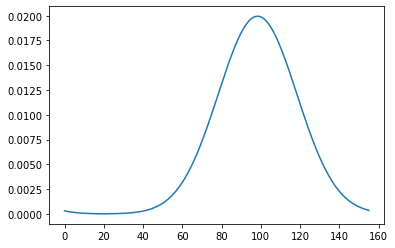

In [28]:
plt.plot(joint_probs[:,70])

## Inspecting our synthetic data

***I'm actually not sure in what respects this data has to look like our empirical data***

1) Number of spikes over entire dataset

In [192]:
print(sum(data_matrix.flatten()))
print(sum(spikes.flatten()))

816688.0
1263171.0


2) Number of unique vectors

In [204]:
spikes_reshaped = np.transpose(spikes, (0,2,1))
spikes_reshaped = np.reshape(spikes_reshaped, (487*2001, 131))
unique_spikes = np.unique(spikes_reshaped, axis=0)
print('Number unique vectors in Empirical data:',str(unique_spikes.shape[0]))

spikes_reshaped = np.transpose(data_matrix, (0,2,1))
spikes_reshaped = np.reshape(spikes_reshaped, (487*2001, 131))
unique_spikes = np.unique(spikes_reshaped, axis=0)
print('Number unique vectors in synthetic data:',str(unique_spikes.shape[0]))

Number unique vectors in Empirical data: 113883
Number unique vectors in synthetic data: 26433


In [203]:
data_matrix[0,:,126]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

3) Distribution of zero-blocks

*For reference measurements with empirical spikes, see `allensdk_data_inspection.ipynb`*

In [205]:
# for simpler indexing going to put the data dimension on the outside
# -> reshaping into (trial, sequence, dimension) form (i.e. "tsd")
synthetic_spikes_tsd = np.transpose(data_matrix, (0,2,1))
print(synthetic_spikes_tsd.shape)

(487, 2001, 131)


In [206]:
zero_block_lens = {}

curr_block_len = 0
for trial in range(synthetic_spikes_tsd.shape[0]):
    for time in range(synthetic_spikes_tsd.shape[1]):
        # when we see a zero vector, accumulate the counter
        if (synthetic_spikes_tsd[trial,time] == np.zeros((131,))).all():
            curr_block_len += 1
        # when we don't, check how long the stretch of zeros before was
        else:
            if curr_block_len > 0:
                if curr_block_len in zero_block_lens.keys():
                    zero_block_lens[curr_block_len] += 1
                else:
                    zero_block_lens[curr_block_len] = 1
                curr_block_len = 0

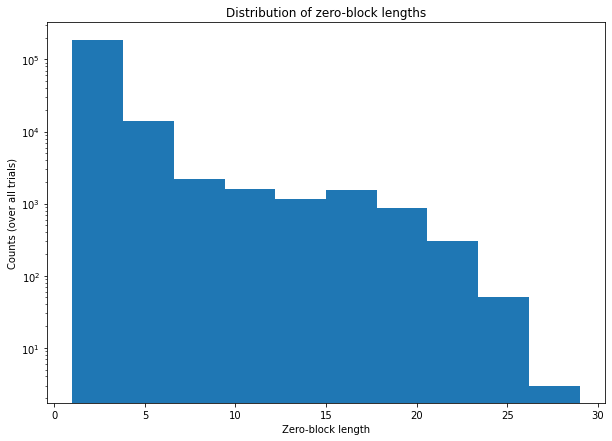

In [207]:
val, weight = zip(*[(k, v) for k,v in zero_block_lens.items()])
plt.figure(figsize=(10,7))
plt.hist(val, weights=weight)
plt.yscale('log')
plt.xlabel('Zero-block length')
plt.ylabel('Counts (over all trials)')
plt.title('Distribution of zero-block lengths')
plt.show()

In [209]:
total_zero_vecs = sum([num*leng for (leng, num) in zero_block_lens.items()])
total_zero_vecs

437453

Average zero-block length:

In [210]:
num_zero_blocks = sum([num for (_, num) in zero_block_lens.items()])
average_zero_block_len = total_zero_vecs/num_zero_blocks
print(average_zero_block_len)

2.078497239459105


Average zero-block length excluding blocks of length=1:

In [211]:
zero_block_lens_geq2 = zero_block_lens.copy()
zero_block_lens_geq2.pop(1)

avg_zblock_geq2 = sum([num*leng for (leng, num) in zero_block_lens_geq2.items()])\
                    /sum([num for (_, num) in zero_block_lens_geq2.items()])

print(avg_zblock_geq2)

3.56647784448741


## Saving the data to the same directory as the empirical data

In [29]:
from datetime import datetime

now = datetime.now()
dt_string = now.strftime("_%H_%M_%S")

with open('../pytorch_experiments/binary_spike_matrix_data/SYNTHETIC_SORTED_sigma20_spike_mtx_'+dt_string+'.npy', 'wb') as f:
    np.save(f, data_matrix)

----

## Need to get the interspike times:

*For consistency, will load in the dataset used in the modeling experiments*

In [45]:
with open('../pytorch_experiments/binary_spike_matrix_data/SYNTHETIC_SORTED_spike_mtx__16_48_50.npy', 'rb') as f:
    dyn_spikes = np.load(f, allow_pickle=True)

In [46]:
dyn_spikes.shape

(487, 131, 2001)

In [47]:
# this list will contain 131 lists of interspike times for each channel
interspike_times = []

curr_ist = 0
for nrn in range(dyn_spikes.shape[1]):
    # list for this specific neuron's ISTs
    nrn_ists = []
    for trial in range(dyn_spikes.shape[0]):
        curr_ist = 0
        for time in range(dyn_spikes.shape[2]):
            if dyn_spikes[trial,nrn,time] == 0:
                curr_ist += 1
            else:
                if curr_ist > 0:
                    nrn_ists.append(curr_ist)
                    curr_ist = 0
    interspike_times.append(nrn_ists)

In [48]:
# np.histogram gives us the (x,y) tuple of x and y coordinate lists for a given
# neuron's histogram
IST_coordinates = []

for nrn in range(len(interspike_times)):
    hist_points = np.histogram(interspike_times[nrn],bins=100)
    # the numpy hist method gives us the bounds on the histogram bins
    # so we'll calculate the list of midpoints
    bin_middles = [(hist_points[1][i] + hist_points[1][i+1])/2 for i in range(len(hist_points[1]) - 1)]
    IST_coordinates.append((bin_middles, hist_points[0]))

In [49]:
# going to store the normalized curves in a different list
normalized_ISTs = []

for (xs, ys) in IST_coordinates:
    y_max = max(ys)
    # for each curve, want to first normalize the y values
    normalized_ys = ys/y_max
    # then we scale the x axis by the x value where we reach y=1/2
    # --> want to iterate over the xs and store the last index where y>1/2
    for i in range(len(xs)):
        if normalized_ys[i] < 0.5:
            x_half = xs[i-1]
            break
    normalized_xs = xs/x_half
    normalized_ISTs.append((normalized_xs, normalized_ys))

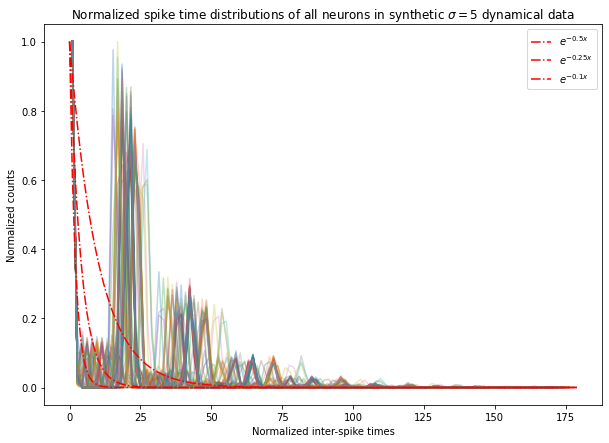

In [50]:
plt.figure(figsize=(10,7))

for (xs,ys) in normalized_ISTs:
        plt.plot(xs, ys, alpha=0.3)

plt.plot(np.arange(180), [np.e**(-0.5*x) for x in np.arange(180)], color='red', linestyle='-.', label=r'$e^{-0.5x}$')
plt.plot(np.arange(180), [np.e**(-0.25*x) for x in np.arange(180)], color='red', linestyle='-.', label=r'$e^{-0.25x}$')
plt.plot(np.arange(180), [np.e**(-0.1*x) for x in np.arange(180)], color='red', linestyle='-.', label=r'$e^{-0.1x}$')

plt.xlabel('Normalized inter-spike times')
plt.ylabel('Normalized counts')
# plt.yscale('log')
plt.title('Normalized spike time distributions of all neurons in synthetic $\sigma=5$ dynamical data')
plt.legend()
plt.savefig('../../Summer/Data 2050/Practicum report/figures/dyn_data_s5_ist_distribution', dpi=300)
plt.show()

## ... and for the $\sigma = 20$ dataset as well

In [33]:
with open('../pytorch_experiments/binary_spike_matrix_data/SYNTHETIC_SORTED_sigma20_spike_mtx__09_08_40.npy', 'rb') as f:
    dyn_spikes = np.load(f, allow_pickle=True)

In [34]:
dyn_spikes.shape

(487, 131, 2001)

In [35]:
# this list will contain 131 lists of interspike times for each channel
interspike_times = []

curr_ist = 0
for nrn in range(dyn_spikes.shape[1]):
    # list for this specific neuron's ISTs
    nrn_ists = []
    for trial in range(dyn_spikes.shape[0]):
        curr_ist = 0
        for time in range(dyn_spikes.shape[2]):
            if dyn_spikes[trial,nrn,time] == 0:
                curr_ist += 1
            else:
                if curr_ist > 0:
                    nrn_ists.append(curr_ist)
                    curr_ist = 0
    interspike_times.append(nrn_ists)

In [36]:
# np.histogram gives us the (x,y) tuple of x and y coordinate lists for a given
# neuron's histogram
IST_coordinates = []

for nrn in range(len(interspike_times)):
    hist_points = np.histogram(interspike_times[nrn],bins=100)
    # the numpy hist method gives us the bounds on the histogram bins
    # so we'll calculate the list of midpoints
    bin_middles = [(hist_points[1][i] + hist_points[1][i+1])/2 for i in range(len(hist_points[1]) - 1)]
    IST_coordinates.append((bin_middles, hist_points[0]))

In [37]:
# going to store the normalized curves in a different list
normalized_ISTs = []

for (xs, ys) in IST_coordinates:
    y_max = max(ys)
    # for each curve, want to first normalize the y values
    normalized_ys = ys/y_max
    # then we scale the x axis by the x value where we reach y=1/2
    # --> want to iterate over the xs and store the last index where y>1/2
    for i in range(len(xs)):
        if normalized_ys[i] < 0.5:
            x_half = xs[i-1]
            break
    normalized_xs = xs/x_half
    normalized_ISTs.append((normalized_xs, normalized_ys))

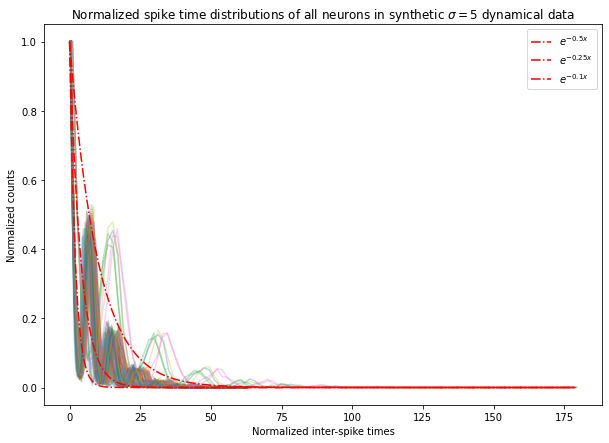

In [44]:
plt.figure(figsize=(10,7))

for (xs,ys) in normalized_ISTs:
        plt.plot(xs, ys, alpha=0.3)

plt.plot(np.arange(180), [np.e**(-0.5*x) for x in np.arange(180)], color='red', linestyle='-.', label=r'$e^{-0.5x}$')
plt.plot(np.arange(180), [np.e**(-0.25*x) for x in np.arange(180)], color='red', linestyle='-.', label=r'$e^{-0.25x}$')
plt.plot(np.arange(180), [np.e**(-0.1*x) for x in np.arange(180)], color='red', linestyle='-.', label=r'$e^{-0.1x}$')

plt.xlabel('Normalized inter-spike times')
plt.ylabel('Normalized counts')
# plt.yscale('log')
plt.title('Normalized spike time distributions of all neurons in synthetic $\sigma=5$ dynamical data')
plt.legend()
plt.savefig('../../Summer/Data 2050/Practicum report/figures/dyn_data_s20_ist_distribution', dpi=300)
plt.show()

In [43]:
spikes_reshaped = np.transpose(spikes, (0,2,1))
spikes_reshaped = np.reshape(spikes_reshaped, (487*2001, 131))
unique_spikes = np.unique(spikes_reshaped, axis=0)
print('Number unique vectors in Empirical data:',str(unique_spikes.shape[0]))

spikes_reshaped = np.transpose(dyn_spikes, (0,2,1))
spikes_reshaped = np.reshape(spikes_reshaped, (487*2001, 131))
unique_spikes = np.unique(spikes_reshaped, axis=0)
print('Number unique vectors in synthetic data:',str(unique_spikes.shape[0]))

Number unique vectors in Empirical data: 113883
Number unique vectors in synthetic data: 58451
